# Timelag Analysis
Build a small module for easily producing timelag maps from stacks of AIA images. Use primarily with simulations, but could be used with observations as well.

In [1]:
import os

import h5py
import numpy as np
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:33805 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [3]:
class AIATimeLags(object):
    """
    Class for easily computing AIA timelag maps from many synthesized AIA observations
    """
    
    def __init__(self, instr, fits_root_path):
        self.instr = instr
        self.ff_format = os.path.join(fits_root_path, f'{instr.name}','{channel}','map_t{i_time:06d}.fits')
        delta_t = np.diff(instr.observing_time.value).cumsum()
        self.timelags = np.hstack([-delta_t[::-1],np.array([0]),delta_t])*self.instr.observing_time.unit
        self.cubes,self.meta_templates = self.load_data()
        
    def load_data(self, **kwargs):
        """
        Create data cubes over desired time range for all channels
        """
        cubes = {}
        meta_templates = {}
        with h5py.File(self.instr.counts_file,'r') as hf:
            instr_time = u.Quantity(hf['time'],hf['time'].attrs['units'])
        with ProgressBar(len(self.instr.channels)*len(self.instr.observing_time),
                         ipython_widget=kwargs.get('notebook',True)) as progress:
            for channel in self.instr.channels:
                cubes[channel['name']] = None
                for i,t in enumerate(self.instr.observing_time):
                    i_time = np.where(t == instr_time)[0][0]
                    tmp = Map(self.ff_format.format(channel=channel['name'], i_time=i_time))
                    if cubes[channel['name']] is None:
                        cubes[channel['name']] = np.empty(tmp.data.shape + self.instr.observing_time.shape)
                    cubes[channel['name']][:, :, i] = tmp.data
                    progress.update()
                meta_templates[channel['name']] = tmp.meta.copy()
            
        return cubes,meta_templates
    
    def make_timeseries(self, cubes, channel, left_corner, right_corner):
        tmp = Map(cubes[channel][:,:,0],self.meta_templates[channel])
        blc = tmp.world_to_pixel(SkyCoord(*left_corner, frame=tmp.coordinate_frame))
        trc = tmp.world_to_pixel(SkyCoord(*right_corner, frame=tmp.coordinate_frame))
        ts = cubes[channel][round(blc.y.value):round(trc.y.value),
                            round(blc.x.value):round(trc.x.value),:].mean(axis=(0,1))
        return ts
    
    def correlation_1d(self, channel_a, channel_b, left_corner, right_corner):
        ts_a = self.make_timeseries(self.cubes, channel_a, left_corner, right_corner)
        ts_b = self.make_timeseries(self.cubes, channel_b, left_corner, right_corner)
        ts_a /= ts_a.max()
        ts_b /= ts_b.max()
        cc = np.fft.irfft(np.fft.rfft(ts_a[::-1], n=self.timelags.shape[0])
                          * np.fft.rfft(ts_b, n=self.timelags.shape[0]), n=self.timelags.shape[0])
        return cc
    
    def correlation_2d(self, channel_a, channel_b, **kwargs):
        """
        Compute cross-correlation between two channels for each pixel in an AIA map 
        """
        # Normalize
        max_a = self.cubes[channel_a].max(axis=2)
        v_a = self.cubes[channel_a]/np.where(max_a==0,1,max_a)[:,:,np.newaxis]
        max_b = self.cubes[channel_b].max(axis=2)
        v_b = self.cubes[channel_b]/np.where(max_b==0,1,max_b)[:,:,np.newaxis]
        return self._dask_correlation(v_a, v_b, chunks=kwargs.get('chunks', None))
    
    def _dask_correlation(self, array_a, array_b, chunks=None):
        """
        Create Dask task graph to compute cross-correlation using FFT
        """
        # Create Dask arrays
        if chunks is None:
            chunks = (int(array_a.shape[0]/20),int(array_a.shape[1]/20))+self.instr.observing_time.shape
        darray_a = dask.array.from_array(array_a[:,:,::-1], chunks=chunks)
        darray_b = dask.array.from_array(array_b, chunks=chunks)
        # Build task graph
        fft_a = dask.array.fft.rfft(darray_a, axis=2, n=self.timelags.shape[0])
        fft_b = dask.array.fft.rfft(darray_b, axis=2, n=self.timelags.shape[0])
        cc = dask.array.fft.irfft(fft_a*fft_b, axis=2, n=self.timelags.shape[0])
        return cc
    
    def make_timelag_map(self, channel_a, channel_b, correlation_threshold=1.):
        """
        Compute map of timelag associated with maximum cross-correlation between
        two channels in each pixel of an AIA map.
        """
        cc = self.correlation_2d(channel_a,channel_b).compute()
        max_cc = np.max(cc,axis=2)
        max_timelag = self.timelags[np.argmax(cc,axis=2)]
        max_timelag = np.where(max_cc<correlation_threshold,0,max_timelag)
        # Metadata
        meta = self.meta_templates[channel_a].copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta_cc = meta.copy()
        meta_cc['bunit'] = ''
        meta_cc['comment'] = f'{channel_a}-{channel_b} cross-correlation'
        meta_timelag = meta.copy()
        meta_timelag['unit'] = 's'
        meta_timelag['comment'] = f'{channel_a}-{channel_b} timelag'

        plot_settings = {'cmap':'plasma'}
        correlation_map = GenericMap(max_cc,meta_cc,plot_settings=plot_settings)
        plot_settings = {'cmap':'RdBu','vmin':self.timelags.value.min(),'vmax':self.timelags.value.max()}
        timelag_map = GenericMap(max_timelag,meta_timelag,plot_settings=plot_settings)
        
        return correlation_map,timelag_map

In [4]:
aia_ieq = InstrumentSDOAIA([0,10000]*u.s)
aia_ieq.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/cooling/ieq/SDO_AIA_counts.h5'
aia_nei = InstrumentSDOAIA([0,10000]*u.s)
aia_nei.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/SDO_AIA_counts.h5'

In [5]:
tl_ieq = AIATimeLags(aia_ieq, '/storage-home/w/wtb2/data/timelag_synthesis/cooling/ieq/')

FloatProgress(value=0.0)

In [13]:
tl_nei = AIATimeLags(aia_nei, '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/')

FloatProgress(value=0.0)

In [ ]:
xc,yc = -280*u.arcsec,-140*u.arcsec
dx,dy = 5*u.arcsec,5*u.arcsec
xrange = (xc-dx/2,yc-dy/2)
yrange = (xc+dx/2,yc+dy/2)

In [ ]:
plt.figure(figsize=(10,10))
for i,channel in enumerate(aia_ieq.channels):
    ts_ieq = tl_ieq.make_timeseries(tl_ieq.cubes,channel['name'],xrange,yrange)
    plt.plot(aia_ieq.observing_time,
             ts_ieq,#/ts_ieq.max(),
             label=channel['name'],ls='-',color=f'C{i}')
    ts_nei = tl_nei.make_timeseries(tl_nei.cubes,channel['name'],xrange,yrange)
    plt.plot(aia_nei.observing_time,
             ts_nei,#/ts_nei.max(),
             ls='--',color=f'C{i}')
plt.legend()
#plt.xlim(0,2000)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(10,8))
for i,p in enumerate([('335','171'),('94','171'),('94','335'),('335','211'),('193','171'),('171','131')]):
    cc_ieq = tl_ieq.correlation_1d(*p, xrange, yrange)
    cc_nei = tl_nei.correlation_1d(*p, xrange, yrange)
    plt.plot(tl_ieq.timelags,cc_ieq/cc_ieq.max(),color=f'C{i}',ls='-',label='{}-{}'.format(*p))
    plt.plot(tl_nei.timelags,cc_nei/cc_nei.max(),color=f'C{i}',ls='--')
plt.axvline(x=0,ls='--',color='k')
plt.xlim([-6e3,6e3])
plt.legend()

In [6]:
cc_map,tl_map = tl_ieq.make_timelag_map('335','171')

In [14]:
cc_map_nei,tl_map_nei = tl_nei.make_timelag_map('335','171')

tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:35139, threads: 1>>
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/nanny.py", line 254, in memory_monitor
    self.process.process.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:35139, threads: 1>>
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/nanny.py", line 254, in memory_

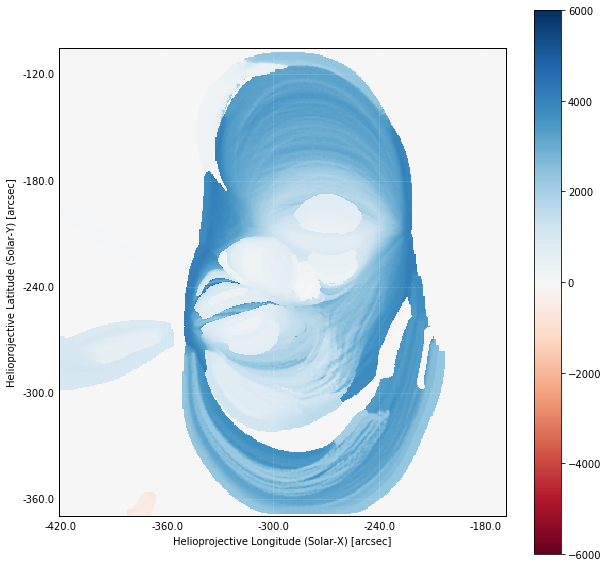

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map)
tl_map.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

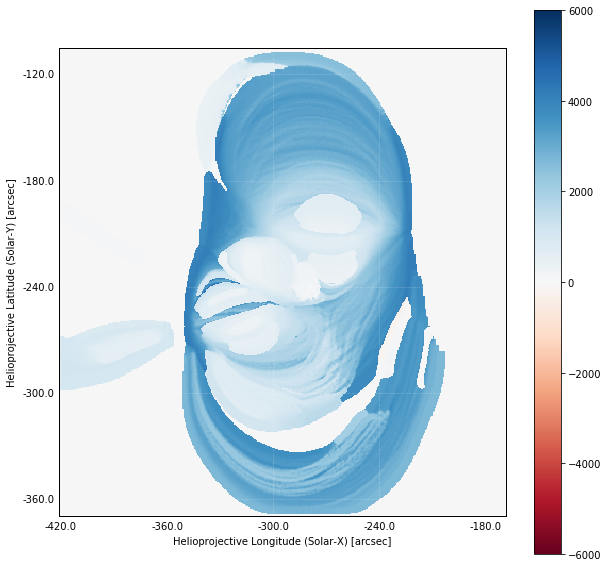

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_nei)
tl_map_nei.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

(-6000.0, 6000.0)

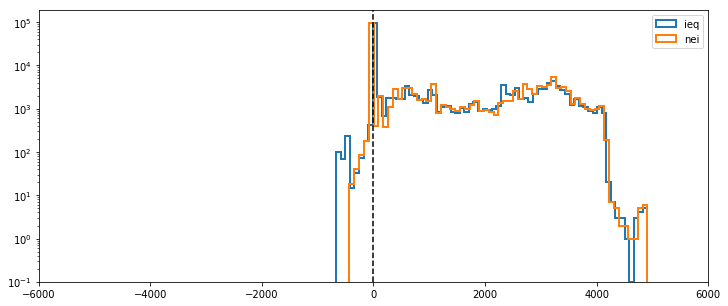

In [18]:
params = {'log':True,'bins':'fd','histtype':'step','lw':2,'normed':False}
plt.figure(figsize=(12,5))
plt.hist(tl_map.data.flatten(),**params,label='ieq',color='C0')
plt.hist(tl_map_nei.data.flatten(),**params,label='nei',color='C1')
plt.axvline(x=0,ls='--',color='k')
plt.legend()
plt.xlim(-6e3,6e3)

In [19]:
client.close()

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7f5b30261ea0>, <tornado.concurrent.Future object at 0x7f59e459b400>)
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/comm/tcp.py", line 174, in read
    n_frames = yield stream.read_bytes(8)
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/core.